In [95]:
from pippi.soundbuffer import SoundBuffer
from pippi import dsp,fx
import numpy as np
import pandas as pd
import sounddevice as sd
import helpers as hp
import param_generation as pg
import _pickle as pickle
from IPython.display import Audio
import librosa
import librosa.feature
import imp 
import os, random
import warnings
from IPython.display import IFrame
from PIL import Image
import matplotlib.ticker as ticker
warnings.filterwarnings('ignore')

imp.reload(hp)
sr=48000
import torch
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from feature_extraction import pytorch_models as pm
import torchaudio as ta
import torchaudio
import torchvision as tv
import matplotlib.pyplot as plt
from IPython.display import Audio
from feature_extraction import mir_utils as miru
from torch.utils.data import Dataset, DataLoader
import librosa
import librosa.display

imp.reload(miru)
SR=44100
spec=torchaudio.functional.spectrogram
db_name="sample_swap_free_final"
drum_df=pd.concat([miru.audioFrames(db_name="radar",loadCache=True, path = "./feature_extraction/drum_dbs/"),
                   miru.audioFrames(db_name="sample_swap",path = "./feature_extraction/drum_dbs/",loadCache=True)])


####
#defining transformations
class freqTrans(object):
    def __init__(self,num_mels=50,SR=SR):
        self.num_mels=num_mels
        self.ampT=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=30)
        self.melF=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
        
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR//4
        wf=wf[:,0:24000]
        num_bins=wf[0].shape[0]
        win_length=num_bins
        hop_step=sample_length//(self.num_mels)
        window=torch.tensor([1]*win_length)
        s=spec(wf, 100, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melF(s)
        s=self.ampT(s)
        freq=s.sum(axis=0).sum(axis=1)
        freq=freq-freq.min()
        freq=freq/freq.max()
        freq[torch.isnan(freq)]=0
        return {"feats":freq.detach(),"label":label}

class envTrans(object):
    def __init__(self,num_mels=10,SR=SR):
        self.env_size=9
        self.num_mels=num_mels
        self.amp=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=60)
        self.melEnv=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
#         self.norm= transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        
        wf=wf.reshape(-1,len(wf))
        sample_length=SR
        num_bins=wf[0].shape[0]
        win_length=SR//20
        hop_step=SR//self.env_size
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window,win_length, hop_step, win_length,2,normalized=False)
        s=self.melEnv(s)
        s=self.amp(s)
#         s=self.norm(s)
        #normalizing
        env=s.sum(axis=0).sum(axis=0)
        env=env-env.min()
        env=env/env.max()
        env[torch.isnan(env)]=0

        num_padding=torch.max(torch.tensor([self.env_size+1-env.shape[0],0]))
        env_vec=torch.cat([env.detach(),torch.zeros(num_padding)],dim=0)
        return {"feats":env_vec.detach(),"label":label}

class feats_and_env(object):
    def __init__(self,feat_mels=50,env_mels=1):
        self.ft=freqTrans(num_mels=feat_mels)
        self.et=envTrans(num_mels=env_mels)

    def __call__(self, sample):
            combined_feats=torch.cat((self.ft(sample)["feats"],self.et(sample)["feats"]))
            return {"feats":combined_feats,"label":sample["label"]}
        

class specTrans(object):
    def __init__(self,num_mels=50,SR=SR,time_steps=20):
        self.num_mels=num_mels
        self.ampP=torchaudio.transforms.AmplitudeToDB(stype='power',top_db=60)
        self.melP=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR,n_stft=None)
        self.hop_step=time_steps-1
    def __call__(self, sample):
        
        wf,label,p,drum_type=sample["signal"],sample["label"],sample["path"],sample["drum_type"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR

        num_bins=wf[0].shape[0]
        win_length=SR//17
        hop_step=SR//self.hop_step
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melP(s)
        s= self.ampP(s)
        s = s - s.min()
        s = s/s.abs().max()
        freq=s
        freq[torch.isnan(freq)]=0
        freq=freq[0]
        return {"feats":freq.detach(),"label":label,"path":p,"drum_type":drum_type}

def MakeSpecs(tfList, plt):
    for i, tsfrm in enumerate(tfList):
        transformed_sample = tsfrm(sample)
        ax = plt.subplot(1, 3, i + 1)
        plt.tight_layout()
        ft=transformed_sample["feats"]
        if i==0:
            plt.title("Frequency Features",fontsize=20)
            plt.xlabel("Frequency Bin",fontsize=20)
            plt.ylabel("Scaled Magnitude",fontsize=20)
            plt.scatter(y=ft,x=range(0,len(ft)))
        if i==1:
            plt.title("Envelope Features",fontsize=20)
            plt.xlabel("Time Step",fontsize=20)
            plt.ylabel("Scaled Magnitude",fontsize=20)            
            plt.scatter(y=ft,x=range(0,len(ft)))
        if i==2:
            print(ft.shape,)
            sf=ft.detach().numpy()
            ft=ft.detach().numpy()
            plt.title("Spectrum Features",fontsize=20)
            librosa.display.specshow(sf,cmap='gray_r',)
            plt.xlabel("Time Step",fontsize=20)
            plt.ylabel("Magnitude of Bin",fontsize=20)
############
import sys
from joblib import dump, load
sys.path.append("..")
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt
import imp
from pathlib import Path

from pippi.soundbuffer import SoundBuffer
from pippi import dsp,fx
import param_generation as pg

import _pickle as pickle
from IPython.display import Audio
from feature_extraction.mir_utils import *

import torch.utils.data as utils
import torchvision.transforms as transforms
from PIL import Image
import common_vars as comv

import csv
import helpers
imp.reload(helpers)
imp.reload(comv)
imp.reload(pg)
from feature_extraction import pytorch_models as tm
from feature_extraction import pytorch_models as pm
imp.reload(tm)
from helpers import *

from common_vars import SR
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_path="./generated_sample_pack/"
# device = "cpu"
stack_size=3
BATCH_SIZE=1
NUM_BINS=100

classes=comv.classes
classes_ranked=comv.classes_ranked
cDict={v:i for i,v in enumerate(classes)}

drum_groups=['snare','kick','hat','other','clap']


def model_loader(m,p):
    s=torch.load(p) 
    m.load_state_dict(s)
    m.to(device)
    return m


imp.reload(pm)

input_dim = 120
seq_dim=100
output_size = 5
hidden_dim = 1000
n_layers = 1

    
#########DVN#########
#env model stuff
env_model_dvn = tm.env_Model(D_in=10,H1=10,H2=5,H3=10,H4=2,H5=10,device=device)
state='./feature_extraction/models/fc/env_dvn_95_35.pt'

env_model_dvn.load_state_dict(torch.load(state))
env_trans=tm.envTrans()
env_model_dvn.to(device)


# pitch model stuff
fc_spec_model_dvn=tm.getFCSpecModel(D_in=20*20,H1=20,H2=10,H3=4,D_out=2)
# state='./feature_extraction/models/fc/spec_fc_dvn_96.pt'
state='./feature_extraction/models/fc/final_spec_fc_dvn_97.pt'

fc_spec_model_dvn.load_state_dict(torch.load(state))
fc_spec_trans_dvn=tm.specTrans(20)
fc_spec_model_dvn.to(device)

#cnn lstm
cnn_model_dvn=pm.CNNLSTM_dvn()
# state='./feature_extraction/models/cnn/clst_dvn_96_279.pt'
state='./feature_extraction/models/cnn/final_clst_dvn_98_401.pt'

cnn_model_dvn.load_state_dict(torch.load(state))
cnn_model_dvn.to(device)
cnn_model_dvn.to(device)
#########DVD#########
#fc dvd
dvd_fc=pm.getFCSpecModel(D_in=20*20,H1=100,H2=50,H3=100,D_out=len(drum_groups))
# state='./feature_extraction/models/fc/spec_fc_dvd_81.pt'
state='./feature_extraction/models/fc/final_spec_fc_dvd_76.pt'
dvd_fc.load_state_dict(torch.load(state))
dvd_fc.to(device)

#cnn_dvd
dvd_cnn=pm.CNN_dvd(len_out=len(drum_groups))
# state='./feature_extraction/models/cnn/clst_dvd_90_170.pt'
state='./feature_extraction/models/cnn/final_cslt_dvd_86_94.pt'
dvd_cnn.load_state_dict(torch.load(state))
dvd_cnn.to(device)

#freq+env model
freq_env_model_dvd = tm.env_freq_Model(D_in=60,H1=30,H2=10,H3=10,D_out=len(drum_groups))
# state='./feature_extraction/models/fc/freq_env_dvd_86_351.pt'
state='./feature_extraction/models/fc/final_freq_env_dvd_85_205.pt'
freq_env_model_dvd.load_state_dict(torch.load(state))
freq_env_trans=tm.freq_and_env_Trans(feat_mels=50,env_mels=1)
freq_env_model_dvd.to(device)



from IPython.display import Audio
import librosa.display

for g in drum_groups:
    Path(save_path+"/"+g).mkdir(parents=True, exist_ok=True)


imp.reload(pm)

input_dim = 120
seq_dim=100
output_size = 5
hidden_dim = 1000
n_layers = 1
from IPython.display import Audio
import librosa.display

for g in drum_groups:
    Path(save_path+"/"+g).mkdir(parents=True, exist_ok=True)

#making graphs of models

from torchsummary import summary
import imp as imp
out,params= stackMaker(stack_size)
a= memToAud(out)
transform_input= {"signal":torch.tensor(a,dtype=torch.float),"label":torch.tensor(0)}
env_feats=env_trans.call(transform_input)["feats"].to(device)
freq_feats=freq_env_trans.call(transform_input)["feats"].to(device)
pitch_feats=fc_spec_trans_dvn.call(transform_input)["feats"].to(device)
spec_flat=torch.flatten(pitch_feats, start_dim=1)

outputEnvFreq=freq_env_model_dvd(freq_feats)
outputCNNDVD=dvd_cnn(pitch_feats.reshape(-1,1,20,20))
outputFCDVD=dvd_fc(spec_flat)
outputE=env_model_dvn(env_feats)
outputSPECFC=fc_spec_model_dvn(spec_flat)
outputCNN= cnn_model_dvn(pitch_feats.reshape(-1,1,20,20))


# summary(freq_env_model_dvd,freq_feats.shape)

model,x=freq_env_model_dvd,freq_feats
model,x=dvd_cnn,pitch_feats.reshape(-1,1,20,20)
model,x=cnn_model_dvn,pitch_feats.reshape(-1,1,20,20)
model,x=cnn_model_dvn,pitch_feats.reshape(-1,1,20,20)



def evalSoundSlow(a,env_thresh=0.5,fc_spec_tresh=0.5):
    try:
        a=librosa.util.normalize(a)
    except:
        pass
    transform_input= {"signal":torch.tensor(a,dtype=torch.float),"label":torch.tensor(0)}
    env_feats=env_trans.call(transform_input)["feats"].to(device)
    freq_feats=freq_env_trans.call(transform_input)["feats"].to(device)
    pitch_feats=fc_spec_trans_dvn.call(transform_input)["feats"].to(device)
    spec_flat=torch.flatten(pitch_feats, start_dim=1)

    outputEnvFreq=freq_env_model_dvd(freq_feats)
    outputCNNDVD=dvd_cnn(pitch_feats.reshape(-1,1,20,20))
    outputFCDVD=dvd_fc(spec_flat)
    outputE=env_model_dvn(env_feats)
    outputSPECFC=fc_spec_model_dvn(spec_flat)
    outputCNN= cnn_model_dvn(pitch_feats.reshape(-1,1,20,20))
    
    o_e,o_fc_spec,o_cnn_spec=outputE[0].item(), outputSPECFC[0][0].item() ,outputCNN[0][0].item()
    tote=outputE[0].item()+outputSPECFC[0][0].item()

    gfc=drum_groups[torch.argmax(outputFCDVD).item()]
    gcnn=drum_groups[torch.argmax(outputCNNDVD).item()]
    genvfreq=drum_groups[torch.argmax(outputEnvFreq).item()]
    cat_consensus=drum_groups[torch.argmax(outputFCDVD+outputCNNDVD+outputEnvFreq)]
    
    spec_score=(o_fc_spec+o_cnn_spec)/2
    if (o_e>=env_thresh) and (o_cnn_spec<fc_spec_tresh or o_fc_spec<fc_spec_tresh):
        print("\x1b[31m\"Decision 1:\"\x1b[0m")
        print("env model ->",o_e)
        print("fc model ->",1 - o_fc_spec)
        print("CNN model -> ",1 - o_cnn_spec)
        print("\x1b[31m\"Decision 2:\"\x1b[0m")
        print("fc category ->",gfc,"\ncnn category ->",gcnn,"\nenv+freq->",genvfreq)
        
        return(a,env_feats,freq_feats,pitch_feats,stack_size,"found")
    return (a,env_feats,freq_feats,pitch_feats,stack_size,"not_found")

def findDrum(stack_size=1,iteration=0):
    out,params = stackMaker(stack_size)
    a = memToAud(out)
    return evalSoundSlow(a,env_thresh=0.5, fc_spec_tresh=0.3)
def tpe_run():
    i,j = 0,0
    while i<1000:
        i, j = i+1,j+1
        stack_size=np.random.choice([2])
        (a,env_feats,freq_feats,pitch_feats,stack_size,results)=findDrum(stack_size,iteration=i)
        if results!="not_found":
            print("\nit took %d iteration(s), stack size %d"%(j,stack_size))
            break
        print(i, end="\r")
    fig = plt.figure(figsize=(15,3))
    ax = plt.subplot(1, 2,1)
    plt.plot(env_feats.cpu())
    ax = plt.subplot(1,2,2)
    ft = pitch_feats.cpu()
    ft = ft.numpy()
    librosa.display.specshow(ft[0])
    return a
   

loading data base from ./feature_extraction/drum_dbs/radar ./feature_extraction/drum_dbs/radar.dill
loading data base from ./feature_extraction/drum_dbs/sample_swap ./feature_extraction/drum_dbs/sample_swap.dill


## Make Your Own Audience
#### Virtual Listeners Can Filter Generated Drum Programs
<table><tr>
<td> 
  <p align="center">
    <img alt="Routing" src="presentation_data/me.jpg" width="320", height = 100%>
    <br>
    <em style="color: black; font-size:20px">Amir Salimi<br> asalimi@ualberta.ca</em>
  </p> 
</td>
<td> 
  <p align="center" style="padding: 10px">
    <img alt="Forwarding" src="prof_abram.jpg" width="320", height = 50%>
    <br>
    <em style="color: black; font-size:20px">Abram Hindle <br> hindle1@ualberta.ca </em>
  </p> 
</td>

</tr></table>


#### What we did:
- Created Synthesizer programs
- Curated datasets of drums (shared it with you)
- Created virtual listeners that prefer drums
- Virtual listeners judge sounds
- Analyzed sounds that are judged positively (they're actually good sometimes)

In [132]:
IFrame("./presentation_data/pipeline.pdf", width=1000, height=500)

# Synthesizer, and Synthsizer Modules:
- No Neural Nets, Only DSP
- Built with:
    - ~ 90% https://github.com/luvsound/pippi
    - ~ 10% https://www.scipy.org/
    - ~100% reason to remember the name

In [131]:
IFrame("./presentation_data/synthesizer_all_blocks.pdf", width=1200, height=800) 

### Synthesizer Sub-Module Paramters:
| Parameters       | Value Range     | Notes and Constraints                            |
|------------------|-----------------|--------------------------------------------------|
| Attack           | 0\-3            | A\-D\-S\-R values relative                       |
| Decay            | 0\-3            | relative to A\-S\-R                              |
| Sustain          | 0\-3            | relative to A\-D\-R                              |
| Release          | 0\-3            | relative to A\-D\-S                              |
| OSC type         | sine,square,saw | \-                                               |
| IsNoise          | boolean         | generate noise using  cloud of waveform |
| Length           | 0\-1 second     | \-                                               |
| StartTime        | 0\-1 second     | Length\+Start$<$1                                |
| Amplitude        | 0\.1\-1         | 1 = max amplitude                                |
| Pitches\(notes\) | list of pitches | range of C0\(16\.35hz\) to B9                    |
| HP filter Cutoff | 0\-20000hz      | \-                                               |
| LP filter Cutoff | 20000hz\-HP     | never lower than HP cutoff                       |
| Filter Order     | 4,8,16          | butterworth filter order                         |

## Creating Sounds via Random Synth. Parameters

CPU times: user 74.2 ms, sys: 117 µs, total: 74.3 ms
Wall time: 73.3 ms


<Figure size 576x360 with 0 Axes>

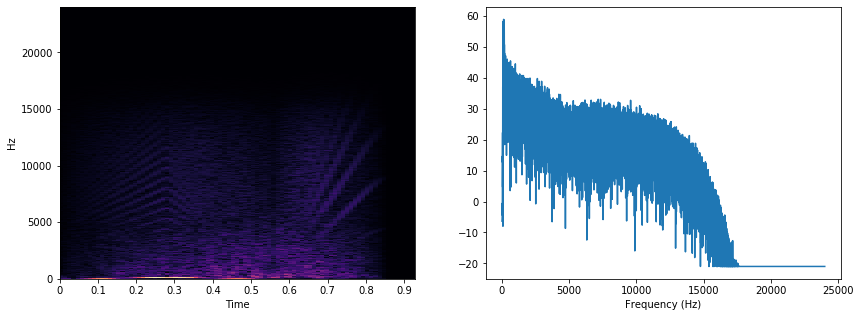

In [182]:
%%time
out = dsp.buffer(length = 1, channels = 1)
params = []; stack_num = 4; params = [pg.RandomParams() for i in range(stack_num)]
sound = pg.ensemble(params)
hp.specShow(sound)
# for i, p in enumerate(params):
#     print("submodule %d Paramters:"%(i,))
#     print(p.__dict__)
# print("\n")
# Audio(sound,rate = sr, autoplay = True)


### So... we can make noise. What now?
- But how do we select ones that sound like drums?
- We need a virtual ear!
    - Decision 1: Recognizes drums from not-drums
    - Decision 2: Given a drum, it can categorize the type of drum
- We probably will need:
    1. Some data to learn from
    2. Simpler forms of sound representation
    3. Models which can learn

### Maybe these datasets can help
#### Download links will be provided (or see paper)
| DB Name   | Categories                                                     |
|-----------|----------------------------------------------------------------|
| FreeDB    | Kicks:533 \- Snares:372 \- Claps:230 \- Hats:105 \- Other:281  |
| RadarDB   | Kicks:1054 \- Snares:842 \- Claps:353              |
| MixedDB   | Kicks:533 \- Snares:372 \- Claps:230 \- Hats:105 \- Others:281 |
| NoiseDB | Generatable                                                    | 1 Stack:2000 3 Stacks:2000  5 Stacks:2000 |


### How do We Represent Sounds?

hat
torch.Size([30, 18])


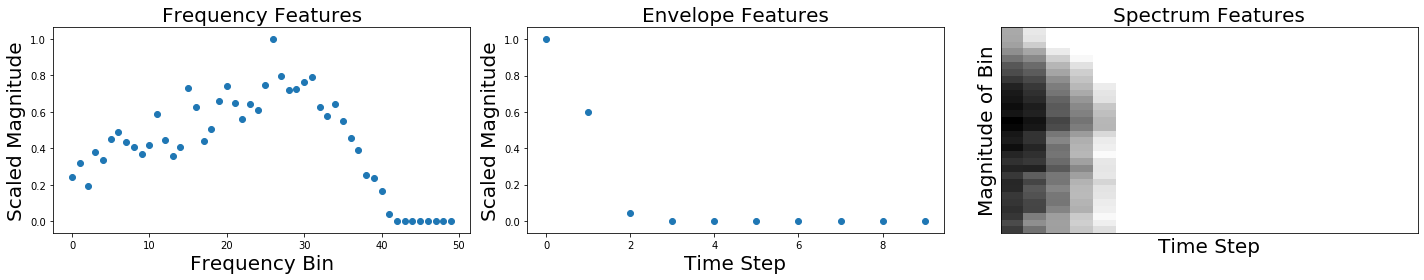

In [190]:
from feature_extraction import pytorch_models as pm
FREQ_BINS=30
TIME_STEPS=20
fig = plt.figure(figsize=(20,4))
ds=pm.audioDataset(pd.concat([drum_df],sort=False),"./",task="dvn",)
sample = ds[np.random.randint(len(drum_df))] 
sample={"signal":sample["signal"],"label":sample["label"],"path":sample["path"],"drum_type":sample["drum_type"]}
print(sample["drum_type"])
tfList=[freqTrans(50),envTrans(num_mels=10,SR=SR),specTrans(FREQ_BINS,time_steps=TIME_STEPS)]
MakeSpecs(tfList, plt)
Audio(sample["signal"],rate=SR,autoplay=False)

### Model Types:
- Two Phased Ears
   - Decision 1, then Decision 2
- Mixed Ear Models:
    - Further condense the representation and make both decisions together

In [174]:
#TPE Ears 
IFrame("./presentation_data/TPE_ear.pdf",width=1500, height=1000)

"Decision 1:"
env model -> 0.9896395206451416
fc model -> 0.10330706834793091
CNN model ->  0.9156935811042786
"Decision 2:"
fc category -> snare 
cnn category -> kick 
env+freq-> snare

it took 787 iteration(s), stack size 3


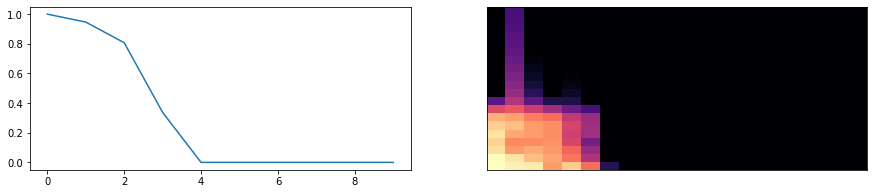

In [161]:
 a = tpe_run()
Audio(a,rate=sr, autoplay=False)

"Decision 1:"
env model -> 0.9504578709602356
fc model -> 0.17102301120758057
CNN model ->  0.9475253596901894
"Decision 2:"
fc category -> hat 
cnn category -> hat 
env+freq-> clap

it took 566 iteration(s), stack size 3


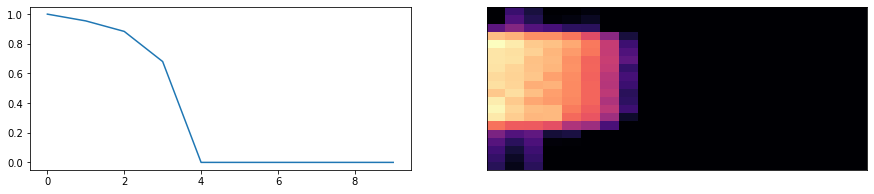

In [64]:
a = tpe_run()
Audio(a,rate=sr, autoplay=False)

Decision 1:
env model -> 0.8620225787162781
fc model -> 0.09219074249267578
CNN model ->  0.9229608178138733
Decision 2:
fc category -> snare 
cnn category -> other 
env+freq-> snare

it took 279 iteration(s), stack size 3


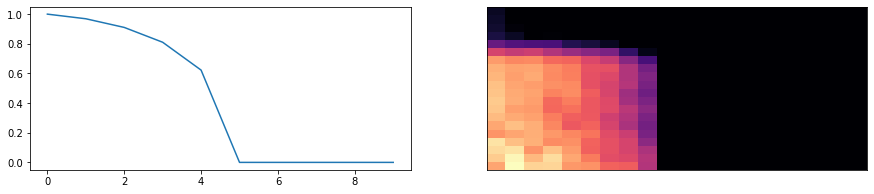

In [9]:
a = tpe_run()
Audio(a,rate=sr, autoplay=False)

Decision 1:
env model -> 0.9529331922531128
fc model -> 0.8827129676938057
CNN model ->  0.9266852214932442
Decision 2:
fc category -> hat 
cnn category -> clap 
env+freq-> clap

it took 101 iteration(s), stack size 3


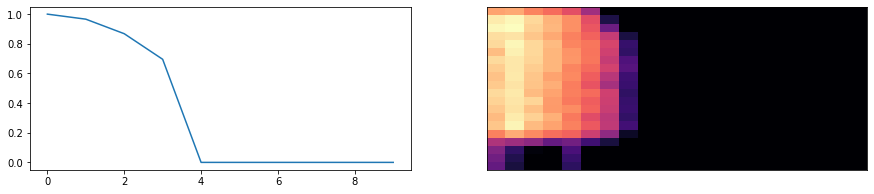

In [10]:
a = tpe_run()
Audio(a,rate=sr, autoplay=False)

In [11]:
# Survey distribution for TPE pipeline
IFrame("./structural_notebooks/cat_2p.pdf", width=1200, height=500) 

### Fleiss Kappa Coefficients for  TPE Survey
| Drop Rule                           | Size | HvH   | H\+FC | H\+CNN | H\+E/F | 3 models |
|-------------------------------------|------|-------|-------|--------|--------|----------|
| No Drops                            | 257  | 0\.37 | 0\.35 | 0\.36  | 0\.36  | 0\.28    |
| Assigned "Bad" By Both              | 236  | 0\.31 | 0\.37 | 0\.37  | 0\.38  | 0\.30    |
| Assigned "Bad" By Either            | 180  | 0\.47 | 0\.50 | 0\.48  | 0\.48  | 0\.34    |
| Assigned "Bad" or "Other" By Either | 154  | 0\.47 | 0\.59 | 0\.54  | 0\.50  | 0\.35    |


In [12]:
# MEM Models
IFrame("./presentation_data/MEM_ear.pdf", width=1500, height=600)

In [87]:
# Running encoding and decoding recursively 
IFrame("./presentation_data/t-SNE_2d.pdf", width=1500, height=800)

In [158]:
# Running encoding and decoding recursively
IFrame("./presentation_data/mme_comparisons_mme.pdf", width=1500, height=600)

In [15]:
#MEM survey
IFrame("./structural_notebooks/cat_mme.pdf", width=1500, height=400) 

| Drop Rule                           | Size | HvH    | H\+MME |
|-------------------------------------|------|--------|--------|
| No Drop                             | 300  | 0\.336 | 0\.250 |
| Assigned "Bad" By Both              | 249  | 0\.200 | 0\.260 |
| Assigned "Bad" By Either            | 151  | 0\.460 | 0\.473 |
| Assigned "Bad" or "Other" By Either | 120  | 0\.620 | 0\.587 |


### Recap
- We implemented a virtual synthesizer and virtual ears
- We made them work together to create drum sounds
- Computational overhead is relatively small
    - Sound generation is quick
    - Models are small and train quickly
- Both approaches produce drum samples but...

### Future Work (Collaborations Welcome!)
1. There are a lot of "duds" mixed in, possible causes:
    - Open set recognition 
    - Better models
    - Need to learn quicker with less data
2. A lot of the produced samples sound the same. 
    - Need more powerful synthesizers

1. Project code: https://github.com/imilas/Synths_Stacks_Search
2. FreeDB: https://zenodo.org/record/3994999
3. RadarDB: https://github.com/imilas/Synths_Stacks_Search/tree/master/getting_data
4. Extra Examples: https://zenodo.org/record/3994999

In [118]:
# Questions?

In [119]:
IFrame("./presentation_data/conclusion.pdf", width=1500, height=800)

In [ ]:
# Thanks for listening 